#### Step 1. 导入必要的库和定义全局变量

In [1]:
import os
import torch
import matplotlib.pyplot as plt

from tqdm import tqdm
from nuplan.planning.scenario_builder.scenario_filter import ScenarioFilter
from nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario_utils import ScenarioMapping
from nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario_builder import NuPlanScenarioBuilder
from nuplan.planning.utils.multithreading.worker_parallel import SingleMachineParallelExecutor

from nuplan.planning.training.preprocessing.features.trajectory_utils import convert_absolute_to_relative_poses

from nuplan.planning.training.preprocessing.utils.agents_preprocessing import (
    AgentInternalIndex,
    EgoInternalIndex,
    sampled_past_ego_states_to_tensor,
    sampled_past_timestamps_to_tensor,
    compute_yaw_rate_from_state_tensors,
    filter_agents_tensor,
    pack_agents_tensor,
    pad_agent_states
)

discrete_size = 10

past_time_horizon = 2

future_time_horizon = 8

# number of discrete traj
num_past_poses = discrete_size * past_time_horizon

# number of discrete trajectory points in future horizon
num_future_poses = discrete_size * future_time_horizon

# deal with top 20 closest agents around the ego vehicle
num_agents = 20

# [m] query radius scope relative to the current pose.
radius = 60

# Interpolation method to apply when interpolating to maintain fixed size map elements.
interpolation_method = 'linear'

# name of map features to be extracted.
map_features = [
    'LANE', 
    'ROUTE_LANES', 
    'CROSSWALK'
] 

# maximum number of elements to extract per feature layer.
max_elements = {
    'LANE': 40, 
    'ROUTE_LANES': 10, 
    'CROSSWALK': 5
}      
 
# maximum number of points per feature to extract per feature layer.
max_points = {
    'LANE': 50, 
    'ROUTE_LANES': 50, 
    'CROSSWALK': 30
}

# nuplan arguments
data_path = '/root/nuplan/dataset/nuplan-v1.1/splits/mini'
map_path = '/root/nuplan/dataset/maps'
save_path = '/root/workspace/GameFormer-Planner/ProcessedData'
scenarios_per_type = 1000
total_scenarios = None
shuffle_scenarios = False
debug = False

map_version = "nuplan-maps-v1.0"    
sensor_root = None
db_files = None

# create folder for processed data
os.makedirs(save_path, exist_ok=True)

**Step 2** 获取 NuPlan 的场景信息

In [2]:
def get_filter_parameters(num_scenarios_per_type=20, limit_total_scenarios=None, shuffle=True):
    # nuplan challenge
    scenario_types = [
        'starting_left_turn',
        'starting_right_turn',
        'starting_straight_traffic_light_intersection_traversal',
        'stopping_with_lead',
        'high_lateral_acceleration',
        'high_magnitude_speed',
        'low_magnitude_speed',
        'traversing_pickup_dropoff',
        'waiting_for_pedestrian_to_cross',
        'behind_long_vehicle',
        'stationary_in_traffic',
        'near_multiple_vehicles',
        'changing_lane',
        'following_lane_with_lead',
    ]

    scenario_tokens = None              # List of scenario tokens to include
    log_names = None                     # Filter scenarios by log names
    map_names = None                     # Filter scenarios by map names

    num_scenarios_per_type               # Number of scenarios per type
    limit_total_scenarios                # Limit total scenarios (float = fraction, int = num) - this filter can be applied on top of num_scenarios_per_type
    timestamp_threshold_s = None          # Filter scenarios to ensure scenarios have more than `timestamp_threshold_s` seconds between their initial lidar timestamps
    ego_displacement_minimum_m = None    # Whether to remove scenarios where the ego moves less than a certain amount

    expand_scenarios = False           # Whether to expand multi-sample scenarios to multiple single-sample scenarios
    remove_invalid_goals = True         # Whether to remove scenarios where the mission goal is invalid
    shuffle                             # Whether to shuffle the scenarios

    ego_start_speed_threshold = None     # Limit to scenarios where the ego reaches a certain speed from below
    ego_stop_speed_threshold = None      # Limit to scenarios where the ego reaches a certain speed from above
    speed_noise_tolerance = None         # Value at or below which a speed change between two timepoints should be ignored as noise.

    return scenario_types, scenario_tokens, log_names, map_names, num_scenarios_per_type, limit_total_scenarios, timestamp_threshold_s, ego_displacement_minimum_m, \
           expand_scenarios, remove_invalid_goals, shuffle, ego_start_speed_threshold, ego_stop_speed_threshold, speed_noise_tolerance

def get_scenario_map():
    scenario_map = {
        'accelerating_at_crosswalk': [15.0, -3.0],
        'accelerating_at_stop_sign': [15.0, -3.0],
        'accelerating_at_stop_sign_no_crosswalk': [15.0, -3.0],
        'accelerating_at_traffic_light': [15.0, -3.0],
        'accelerating_at_traffic_light_with_lead': [15.0, -3.0],
        'accelerating_at_traffic_light_without_lead': [15.0, -3.0],
        'behind_bike': [15.0, -3.0],
        'behind_long_vehicle': [15.0, -3.0],
        'behind_pedestrian_on_driveable': [15.0, -3.0],
        'behind_pedestrian_on_pickup_dropoff': [15.0, -3.0],
        'changing_lane': [15.0, -3.0],
        'changing_lane_to_left': [15.0, -3.0],
        'changing_lane_to_right': [15.0, -3.0],
        'changing_lane_with_lead': [15.0, -3.0],
        'changing_lane_with_trail': [15.0, -3.0],
        'crossed_by_bike': [15.0, -3.0],
        'crossed_by_vehicle': [15.0, -3.0],
        'following_lane_with_lead': [15.0, -3.0],
        'following_lane_with_slow_lead': [15.0, -3.0],
        'following_lane_without_lead': [15.0, -3.0],
        'high_lateral_acceleration': [15.0, -3.0],
        'high_magnitude_jerk': [15.0, -3.0],
        'high_magnitude_speed': [15.0, -3.0],
        'low_magnitude_speed': [15.0, -3.0],
        'medium_magnitude_speed': [15.0, -3.0],
        'near_barrier_on_driveable': [15.0, -3.0],
        'near_construction_zone_sign': [15.0, -3.0],
        'near_high_speed_vehicle': [15.0, -3.0],
        'near_long_vehicle': [15.0, -3.0],
        'near_multiple_bikes': [15.0, -3.0],
        'near_multiple_pedestrians': [15.0, -3.0],
        'near_multiple_vehicles': [15.0, -3.0],
        'near_pedestrian_at_pickup_dropoff': [15.0, -3.0],
        'near_pedestrian_on_crosswalk': [15.0, -3.0],
        'near_pedestrian_on_crosswalk_with_ego': [15.0, -3.0],
        'near_trafficcone_on_driveable': [15.0, -3.0],
        'on_all_way_stop_intersection': [15.0, -3.0],
        'on_carpark': [15.0, -3.0],
        'on_intersection': [15.0, -3.0],
        'on_pickup_dropoff': [15.0, -3.0],
        'on_stopline_crosswalk': [15.0, -3.0],
        'on_stopline_stop_sign': [15.0, -3.0],
        'on_stopline_traffic_light': [15.0, -3.0],
        'on_traffic_light_intersection': [15.0, -3.0],
        'starting_high_speed_turn': [15.0, -3.0],
        'starting_left_turn': [15.0, -3.0],
        'starting_low_speed_turn': [15.0, -3.0],
        'starting_protected_cross_turn': [15.0, -3.0],
        'starting_protected_noncross_turn': [15.0, -3.0],
        'starting_right_turn': [15.0, -3.0],
        'starting_straight_stop_sign_intersection_traversal': [15.0, -3.0],
        'starting_straight_traffic_light_intersection_traversal': [15.0, -3.0],
        'starting_u_turn': [15.0, -3.0],
        'starting_unprotected_cross_turn': [15.0, -3.0],
        'starting_unprotected_noncross_turn': [15.0, -3.0],
        'stationary': [15.0, -3.0],
        'stationary_at_crosswalk': [15.0, -3.0],
        'stationary_at_traffic_light_with_lead': [15.0, -3.0],
        'stationary_at_traffic_light_without_lead': [15.0, -3.0],
        'stationary_in_traffic': [15.0, -3.0],
        'stopping_at_crosswalk': [15.0, -3.0],
        'stopping_at_stop_sign_no_crosswalk': [15.0, -3.0],
        'stopping_at_stop_sign_with_lead': [15.0, -3.0],
        'stopping_at_stop_sign_without_lead': [15.0, -3.0],
        'stopping_at_traffic_light_with_lead': [15.0, -3.0],
        'stopping_at_traffic_light_without_lead': [15.0, -3.0],
        'stopping_with_lead': [15.0, -3.0],
        'traversing_crosswalk': [15.0, -3.0],
        'traversing_intersection': [15.0, -3.0],
        'traversing_narrow_lane': [15.0, -3.0],
        'traversing_pickup_dropoff': [15.0, -3.0],
        'traversing_traffic_light_intersection': [15.0, -3.0],
        'waiting_for_pedestrian_to_cross': [15.0, -3.0]
    }

    return scenario_map

scenario_mapping = ScenarioMapping(
    scenario_map=get_scenario_map(), 
    subsample_ratio_override=0.5
)

builder = NuPlanScenarioBuilder(
    data_path, 
    map_path, 
    sensor_root, 
    db_files, 
    map_version, 
    scenario_mapping=scenario_mapping
)

# scenarios for training
scenario_filter = ScenarioFilter(
    *get_filter_parameters(
        scenarios_per_type, 
        total_scenarios, 
        shuffle_scenarios
    )
)

# enable parallel process
worker = SingleMachineParallelExecutor(use_process_pool=True)

# get scenarios
scenarios = builder.get_scenarios(scenario_filter, worker)

# delete useless variables, only deal with scenarios
del worker, builder, scenario_filter, scenario_mapping

**Step 3** 开始处理数据


In [3]:
# get scenario info
scenario = scenarios[100]
map_name = scenario._map_name
token    = scenario.token

# get map api
map_api  = scenario.map_api

$\Rightarrow$ 处理 Ego 数据

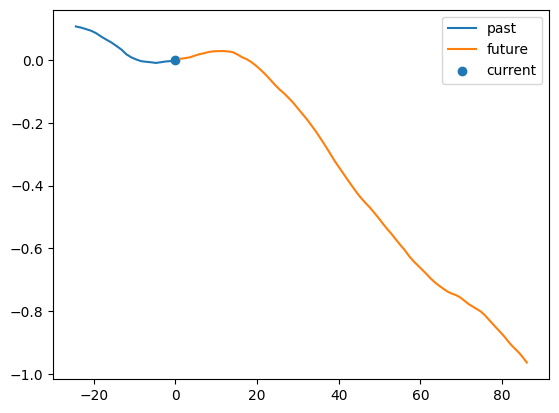

In [4]:
# get ego query state
query_ego_state = scenario.initial_ego_state

# get past ego states in past_time_horizon
past_ego_states = scenario.get_ego_past_trajectory(
	iteration=0,
	num_samples=num_past_poses,
	time_horizon=past_time_horizon
)

# convert absolute poses to relative poses
past_relative_ego_poses = convert_absolute_to_relative_poses(
	query_ego_state.rear_axle, 
 	[state.rear_axle for state in past_ego_states]
)

# get observation time
current_ego_timestamp = scenario.start_time

# get future ego state in future horizon
future_ego_states = scenario.get_ego_future_trajectory(
	iteration=0, 
 	num_samples=num_future_poses, 
  	time_horizon=future_time_horizon
)

# convert absolute poses to relative poses
future_relative_ego_poses = convert_absolute_to_relative_poses(
	query_ego_state.rear_axle, 
 	[state.rear_axle for state in future_ego_states]
)

plt.plot(past_relative_ego_poses[:, 0], past_relative_ego_poses[:, 1], label='past')
plt.plot(future_relative_ego_poses[:, 0], future_relative_ego_poses[:, 1], label='future')
plt.scatter(0, 0, label='current')
plt.legend()

$\Rightarrow$ 处理 Agent 数据

In [6]:
from nuplan.database.nuplan_db.nuplan_scenario_queries import *

def _extract_agent_tensor(tracked_objects, track_token_ids, object_types):
    """
    Extracts the relevant data from the agents present in a past detection into a tensor.
    Only objects of specified type will be transformed. Others will be ignored.
    The output is a tensor as described in AgentInternalIndex
    :param tracked_objects: The tracked objects to turn into a tensor.
    :track_token_ids: A dictionary used to assign track tokens to integer IDs.
    :object_type: TrackedObjectType to filter agents by.
    :return: The generated tensor and the updated track_token_ids dict.
    """
    agents = tracked_objects.get_tracked_objects_of_types(object_types)
    agent_types = []
    output = torch.zeros((len(agents), AgentInternalIndex.dim()), dtype=torch.float32)
    max_agent_id = len(track_token_ids)

    for idx, agent in enumerate(agents):
        if agent.track_token not in track_token_ids:
            track_token_ids[agent.track_token] = max_agent_id
            max_agent_id += 1
        track_token_int = track_token_ids[agent.track_token]

        output[idx, AgentInternalIndex.track_token()] = float(track_token_int)
        output[idx, AgentInternalIndex.vx()] = agent.velocity.x
        output[idx, AgentInternalIndex.vy()] = agent.velocity.y
        output[idx, AgentInternalIndex.heading()] = agent.center.heading
        output[idx, AgentInternalIndex.width()] = agent.box.width
        output[idx, AgentInternalIndex.length()] = agent.box.length
        output[idx, AgentInternalIndex.x()] = agent.center.x
        output[idx, AgentInternalIndex.y()] = agent.center.y
        agent_types.append(agent.tracked_object_type)

    return output, track_token_ids, agent_types

def sampled_tracked_objects_to_tensor_list(past_tracked_objects):
    """
    Tensorizes the agents features from the provided past detections.
    For N past detections, output is a list of length N, with each tensor as described in `_extract_agent_tensor()`.
    :param past_tracked_objects: The tracked objects to tensorize.
    :return: The tensorized objects.
    """
    object_types = [TrackedObjectType.VEHICLE, TrackedObjectType.PEDESTRIAN, TrackedObjectType.BICYCLE]
    output = []
    output_types = []
    track_token_ids = {}

    for i in range(len(past_tracked_objects)):
        tensorized, track_token_ids, agent_types = _extract_agent_tensor(past_tracked_objects[i], track_token_ids, object_types)
        output.append(tensorized)
        output_types.append(agent_types)

    return output, output_types

# Find surrounding agents
current_tracked_objects = scenario.initial_tracked_objects.tracked_objects

past_tracked_objects = [
	tracked_objects.tracked_objects
	for tracked_objects in scenario.get_past_tracked_objects(
		iteration=0,
		time_horizon=past_time_horizon,
		num_samples=num_past_poses
	)
]  

sampled_past_observations = past_tracked_objects + [current_tracked_objects]
past_tracked_objects_tensor_list, past_tracked_objects_types = \
		sampled_tracked_objects_to_tensor_list(sampled_past_observations)


current_ego_state = self.scenario.initial_ego_state
present_tracked_objects = scenario.initial_tracked_objects.tracked_objects

# Get all future poses of of other agents
future_tracked_objects = [
	tracked_objects.tracked_objects
	for tracked_objects in scenario.get_future_tracked_objects(
		iteration=0, time_horizon=future_time_horizon, num_samples=num_future_poses
	)
]

sampled_future_observations = [present_tracked_objects] + future_tracked_objects
future_tracked_objects_tensor_list, _ = sampled_tracked_objects_to_tensor_list(sampled_future_observations)
agent_futures = agent_future_process(query_ego_state, future_tracked_objects_tensor_list, self.num_agents, agent_index)


[tensor([[ 0.0000e+00,  1.3243e-01, -9.2967e+00, -1.5502e+00,  1.9216e+00,
           4.7275e+00,  6.6443e+05,  3.9972e+06],
         [ 1.0000e+00,  3.3153e-01, -1.0459e+01, -1.5415e+00,  2.2430e+00,
           6.1873e+00,  6.6443e+05,  3.9973e+06],
         [ 2.0000e+00,  2.1370e-01, -8.6365e+00, -1.5413e+00,  1.9047e+00,
           4.5827e+00,  6.6443e+05,  3.9972e+06],
         [ 3.0000e+00,  2.6497e-01, -1.6151e+01, -1.5552e+00,  2.2487e+00,
           5.2494e+00,  6.6444e+05,  3.9972e+06],
         [ 4.0000e+00,  2.7254e-01, -1.3503e+01, -1.5452e+00,  2.1673e+00,
           4.8985e+00,  6.6444e+05,  3.9972e+06],
         [ 5.0000e+00,  4.2963e-01, -1.3802e+01, -1.5405e+00,  1.9506e+00,
           4.6837e+00,  6.6444e+05,  3.9973e+06],
         [ 6.0000e+00,  5.4287e-01, -1.0756e+01, -1.5187e+00,  1.9141e+00,
           4.7602e+00,  6.6444e+05,  3.9973e+06],
         [ 7.0000e+00,  5.5656e-01, -1.7550e+01, -1.5355e+00,  1.9879e+00,
           5.7317e+00,  6.6444e+05,  3.9973e+06],
